## Principal component Analysis

In [254]:
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm
from keras import optimizers


pca = PCA(n_components=512)
array = np.load('1_ResNET.npy')
print(array.shape)
pca_arr = pca.fit_transform(array)
np.save('1_ResNET_PCA512.npy', pca_arr)
print(pca_arr.shape)

(5400, 2048)
(5400, 512)


In [255]:
print(array, array.shape)

[[1.4630162  0.06204205 4.4352226  ... 1.5256827  3.5007942  0.        ]
 [1.3390025  0.05157435 4.769183   ... 0.67852765 1.8540585  0.21820806]
 [0.53878206 0.01563736 5.3364444  ... 0.36709633 3.5641797  0.01204965]
 ...
 [0.         0.13242404 4.908689   ... 2.4691331  1.3422186  0.20065752]
 [0.         0.08716917 4.3659477  ... 2.1971464  1.4559647  0.1773672 ]
 [0.         0.07030997 3.5072024  ... 3.0104277  0.9120427  0.00837918]] (5400, 2048)


In [256]:
print(pca_arr, pca_arr.shape)

[[-5.80803347e+00  1.26974983e+01  5.84326935e+00 ... -2.00470481e-02
  -1.66816667e-01 -1.17484175e-01]
 [-9.21681702e-01  1.89238224e+01  2.78410482e+00 ...  4.83036846e-01
  -3.70327920e-01 -2.86788911e-01]
 [ 8.03594708e-01  1.97798786e+01 -2.23761988e+00 ...  2.85647511e-01
  -2.22842529e-01  6.07649505e-01]
 ...
 [-1.23722334e+01 -3.91646206e-01 -2.03146210e+01 ... -1.07324064e-01
   8.55150968e-02 -3.56993735e-01]
 [-1.41052542e+01 -2.34798503e+00 -1.80075951e+01 ...  1.19628981e-01
   2.13056114e-02 -2.79942691e-01]
 [-1.31388531e+01  8.74109864e-01 -1.76793690e+01 ... -1.00771682e-02
   3.32442701e-01 -1.53598383e-01]] (5400, 512)


## Initializing Directories

In [13]:
import numpy as np
import json
import os
import pickle

 Defining the folders and the file names to import

In [52]:
FEAT_FOLDER = 'data/features/'
LABEL_FOLDER = 'data/labels'

FEAT_FILE_1 = '1_ResNET_PCA512.npy'
FEAT_FILE_2 = '2_ResNET_PCA512.npy'

FEAT_FILE = 'feat.pickle'
LABEL_FILE = 'label.pickle'

MODEL = r'C:\Users\ranja\Desktop\Notebooks\SoccerNet-code-master\SoccerNet-code-master\src\feature_extraction\model.json'
WEIGHTS = r'C:\Users\ranja\Desktop\Notebooks\SoccerNet-code-master\SoccerNet-code-master\src\feature_extraction\model.h5'

Checking the contents of the folder

In [15]:
os.listdir(LABEL_FOLDER) 

['england_epl',
 'europe_uefa-champions-league',
 'france_ligue-1',
 'germany_bundesliga',
 'italy_serie-a',
 'spain_laliga']

Creating en empty list that will hold the locations of <br>
 - all the features extracted
 - all the labels parsed
    


In [16]:
FEAT_FOLD_LIST = []
LABEL_FOLD_LIST = []

## Collecting Feature and Label Directories

Executing a tree walk through the features folder, to find all the folders that contain the feature

In [17]:
for root, subdirs, files in os.walk(FEAT_FOLDER):
    if files:
        for f in files:
            if f.endswith('.npy') and root not in FEAT_FOLD_LIST:
                FEAT_FOLD_LIST += [root]

In [18]:
FEAT_FOLD_LIST[:2]

['data/features/england_epl\\2014-2015\\2015-02-21 - 18-00 Chelsea 1 - 1 Burnley',
 'data/features/england_epl\\2014-2015\\2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal']

Executing a tree walk through the labels folder, to find all the folders that contain the labels

In [19]:
for root, subdirs, files in os.walk(LABEL_FOLDER):
    if files:
        for f in files:
            if f.endswith('.json') and root not in LABEL_FOLD_LIST:
                LABEL_FOLD_LIST += [root]

In [20]:
LABEL_FOLD_LIST[:2]

['data/labels\\england_epl\\2014-2015\\2015-02-21 - 18-00 Chelsea 1 - 1 Burnley',
 'data/labels\\england_epl\\2014-2015\\2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal']

## Finding features for labels

Initializing certain static variables

In [21]:
#to determine how many events to iterate through
FILE_LEN = len(FEAT_FOLD_LIST)

#Type of Events taken from labels and assigned to variables
GOAL = "soccer-ball"
FOUL = "y-card"
SUBS = "substitution-in"
NO_EVENT = "no"

#This variable determines how many features around the index we want to take
ws = 10 #5 second window, 5/60 * 2 * 60 = 10

Inititalizing features, making them 512 size

In [22]:
GOAL_FEATURES = np.empty([1, 512])
FOUL_FEATURES = np.empty([1, 512])
SUBS_FEATURES = np.empty([1, 512])
NO_FEATURES = np.empty([1, 512])

Defining helper functions

In [23]:
def get_features(folder):
    
    """
    function : to find and give back the combined set of resnet features
    input : the location of the features
    output : features for the entire match
    """
    
    files = os.listdir(folder)
    if FEAT_FILE_1 not in files or FEAT_FILE_2 not in files:
        return None
    first_half = np.load(folder + '/' + FEAT_FILE_1)
    second_half = np.load(folder + '/' + FEAT_FILE_2)
    return np.concatenate((first_half, second_half))

def get_labels(folder):
    
    """
    function : to find the labels and return
    inpupt : location of labels
    output : labels in json format
    """
    
    file = os.listdir(folder)
    with open(folder + '/' + file[0]) as json_file:
        data = json.load(json_file)
    return data

def parse_labels(labels, size):
    
    """
    function : to return the array of indices of every event type
    input : labels in json format and the size of the features (length)
    output : a dictionary containing an array of values for every event type
    """
    
    annots = labels['annotations']
    
    dict_events = {}
    goal_time = []
    foul_time = []
    subs_time = []
    
    for i in range(len(annots)):
        if annots[i]['label'] == GOAL:
            time = annots[i]['gameTime']
            vals = time.split('-')
            final_time = int(vals[0]) * int(vals[1][0:3])
            final_time = final_time * 120
            if final_time > size:
                final_time = size - ws
            goal_time += [final_time]

        if annots[i]['label'] == FOUL:
            time = annots[i]['gameTime']
            vals = time.split('-')
            final_time = int(vals[0]) * int(vals[1][0:3])
            final_time = final_time * 120
            if final_time > size:
                final_time = size - ws
            foul_time += [final_time]
            
        if annots[i]['label'] == SUBS:
            time = annots[i]['gameTime']
            vals = time.split('-')
            final_time = int(vals[0]) * int(vals[1][0:3])
            final_time = final_time * 120
            if final_time > size:
                final_time = size - ws            
            subs_time += [final_time]
            
    dict_events[GOAL] = goal_time
    dict_events[FOUL] = foul_time
    dict_events[SUBS] = subs_time
    return dict_events

def interpolate(arr, ws):
    
    """
    function : to find features on either side of the value
    input : the array of values and the window size
    output : modified array of indices
    """
    
    new_arr = [list(range(x-ws, x+1)) for x in arr]
    merged_list = []

    for l in new_arr:
        merged_list += l
    return merged_list

Aggregating features of a particular event into respective arrays

In [26]:
for i in tqdm(range(0, 100)):
    feat_dir = FEAT_FOLD_LIST[i]
    label_dir = LABEL_FOLD_LIST[i]
    
    features = get_features(feat_dir)
    if features is None:
        continue
        
    features_small = features
    feat_shape = list(range(features.shape[0]))
    
    labels = get_labels(label_dir)
    
    events = parse_labels(labels, features.shape[0])
    
    g = events[GOAL]
    f = events[FOUL]
    s = events[SUBS]
    
    num = interpolate(g, ws) + interpolate(f, ws) + interpolate(s, ws)
    #print(num) 
    
    y = [not x in num for x in feat_shape]
    
    GOAL_FEATURES = np.concatenate([GOAL_FEATURES, features[interpolate(g, ws)]])
    FOUL_FEATURES = np.concatenate([FOUL_FEATURES, features[interpolate(f, ws)]])
    SUBS_FEATURES = np.concatenate([SUBS_FEATURES, features[interpolate(s, ws)]])
    NO_FEATURES = np.concatenate([NO_FEATURES, features_small[y]])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]


Checking the size...

In [27]:
print(GOAL_FEATURES.shape, FOUL_FEATURES.shape, SUBS_FEATURES.shape, NO_FEATURES.shape)

(2883, 512) (3400, 512) (5303, 512) (966182, 512)


## Training

Making the necessary imports

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Creating Train and Test Features

In [29]:
# Find the minimum length of all the three event feature types
n = min(GOAL_FEATURES.shape[0], FOUL_FEATURES.shape[0], SUBS_FEATURES.shape[0], NO_FEATURES.shape[0])

#Create target class variable of length n
g_class = [GOAL] * n
f_class = [FOUL] * n
s_class = [SUBS] * n
n_class = [NO_EVENT] *n

#Ensure that the train features and target labels are of the same length
TRAIN_FEATURES = np.concatenate([GOAL_FEATURES[:n], FOUL_FEATURES[:n], SUBS_FEATURES[:n], NO_FEATURES[:n]])
#TRAIN_FEATURES = np.concatenate([GOAL_FEATURES[:n], FOUL_FEATURES[:n], SUBS_FEATURES[:n]])

TARGET_LABELS = np.concatenate([g_class, f_class, s_class, n_class])
#TARGET_LABELS = np.concatenate([g_class, f_class, s_class])

print(TRAIN_FEATURES.shape, TARGET_LABELS.shape)

(11532, 512) (11532,)


#### Store

In [61]:
feat_out = open(FEAT_FILE, "wb")

pickle.dump(TRAIN_FEATURES, feat_out)
feat_out.close()

#### Load

In [62]:
pickle_in = open(FEAT_FILE,"rb")

TRAIN_FEATURES = pickle.load(pickle_in)

### Label Enconding and Test Features

Encoding the target varibles to make it suitable for training

In [32]:
encoder = LabelEncoder()
encoder.fit(TARGET_LABELS)
encoded_Y = encoder.transform(TARGET_LABELS)
# convert integers to dummy variables (i.e. one hot encoded)
y = np_utils.to_categorical(encoded_Y)
y.shape

(11532, 4)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(TRAIN_FEATURES, y, test_size=0.2, random_state=42)

### Defining the model

In [218]:
def baseline_model():
    # create model
    model = Sequential()
    
    #512 inputs to 8 neurons
    model.add(Dense(27, input_dim=512, activation='relu'))
    
    #model.add(Dropout(0.5))
    
    model.add(Dense(19, input_dim=27, activation='relu'))
    
    model.add(Dense(11, input_dim=19, activation='relu'))
    
    
    model.add(Dense(7, input_dim=11, activation='relu'))

    #Final 4 categories, so again three dense layers
    model.add(Dense(4))
    
    #Add softmax activation function
    model.add(Activation(tf.nn.softmax))
    
    # Compile model
    
    adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

### Fitting

Creating an instance of the model, and training

In [219]:
model = baseline_model()

In [213]:
model.optimizer.lr = 0.001

In [229]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
9225/9225 [==============================] - ETA: 0s - loss: 0.0487 - acc: 0.968 - ETA: 0s - loss: 0.1319 - acc: 0.951 - ETA: 0s - loss: 0.1395 - acc: 0.952 - ETA: 0s - loss: 0.1490 - acc: 0.947 - ETA: 0s - loss: 0.1656 - acc: 0.944 - ETA: 0s - loss: 0.1649 - acc: 0.943 - ETA: 0s - loss: 0.1584 - acc: 0.944 - ETA: 0s - loss: 0.1580 - acc: 0.945 - ETA: 0s - loss: 0.1582 - acc: 0.944 - ETA: 0s - loss: 0.1620 - acc: 0.943 - 0s 53us/step - loss: 0.1603 - acc: 0.9441
Epoch 2/10
9225/9225 [==============================] - ETA: 1s - loss: 0.0686 - acc: 0.968 - ETA: 0s - loss: 0.1808 - acc: 0.947 - ETA: 0s - loss: 0.1720 - acc: 0.949 - ETA: 0s - loss: 0.1655 - acc: 0.952 - ETA: 0s - loss: 0.1558 - acc: 0.954 - ETA: 0s - loss: 0.1575 - acc: 0.954 - ETA: 0s - loss: 0.1565 - acc: 0.953 - ETA: 0s - loss: 0.1592 - acc: 0.951 - ETA: 0s - loss: 0.1555 - acc: 0.951 - ETA: 0s - loss: 0.1584 - acc: 0.949 - 0s 52us/step - loss: 0.1582 - acc: 0.9493
Epoch 3/10
9225/9225 [======================

## Storing models

In [228]:
model_json = model.to_json()
with open(MODEL, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(WEIGHTS)
print("Saved model to disk")

Saved model to disk


In [174]:
from keras.models import model_from_json


json_file = open(MODEL, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights(WEIGHTS)
print("Loaded model from disk")

Loaded model from disk


## Testing

Predicting on the test set

In [230]:
y_pred = model.predict(X_test)
y_pred[:5]

array([[9.9982077e-01, 1.7918918e-04, 2.4469303e-08, 1.0787985e-07],
       [1.1454955e-13, 9.6298164e-01, 3.1223016e-02, 5.7953559e-03],
       [1.0000000e+00, 8.8053530e-11, 7.8497283e-21, 9.5831262e-19],
       [9.8867692e-10, 5.7549255e-06, 9.9999428e-01, 9.0085066e-12],
       [1.0000000e+00, 3.4630943e-08, 1.0802436e-15, 3.3647147e-14]],
      dtype=float32)

In [231]:
y_test[:5]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)

Converting the test set to 1's and 0's

In [232]:
y_pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)
y_pred[:5]

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0]])

In [233]:
 accuracy_score(y_test, y_pred)

0.7754659731252709

In [234]:
X_train.shape

(9225, 512)

In [235]:
y_train.shape

(9225, 4)

## Accuracy Assessment

In [236]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib notebook

In [237]:
GOAL = "soccer-ball"
FOUL = "y-card"
SUBS = "substitution-in"
NO_EVENT = "no"

In [238]:
def transform(y):
    t = []
    for i in range(len(y)):
        if y[i][0] == 1:
            t += [GOAL]
        if y[i][1] == 1:
            t += [FOUL]
        if y[i][2] == 1:
            t += [SUBS]
        if y[i][3] == 1:
            t += [NO_EVENT]
    return t

In [239]:
a = transform(y_test)
b = transform(y_pred)

In [240]:
cm = confusion_matrix(a, b)

In [241]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

In [242]:
FP

array([128,  26, 183, 181], dtype=int64)

In [243]:
FN

array([214,  26, 132, 146], dtype=int64)

In [244]:
TP

array([382, 549, 418, 440], dtype=int64)

In [245]:
TN

array([1583, 1706, 1574, 1540], dtype=int64)

Calculating Recall

In [247]:
TPR = TP/(TP+FN)
print(TPR)

[0.6409396  0.95478261 0.76       0.75085324]


Calculating Precision

In [249]:
PPV = TP/(TP+FP)
PPV

array([0.74901961, 0.95478261, 0.69550749, 0.70853462])

Calculating Accuracy

In [251]:
ACC = (TP+TN)/(TP+FP+FN+TN)
print(ACC)

[0.85175553 0.9774599  0.86345904 0.85825748]


<IPython.core.display.Javascript object>


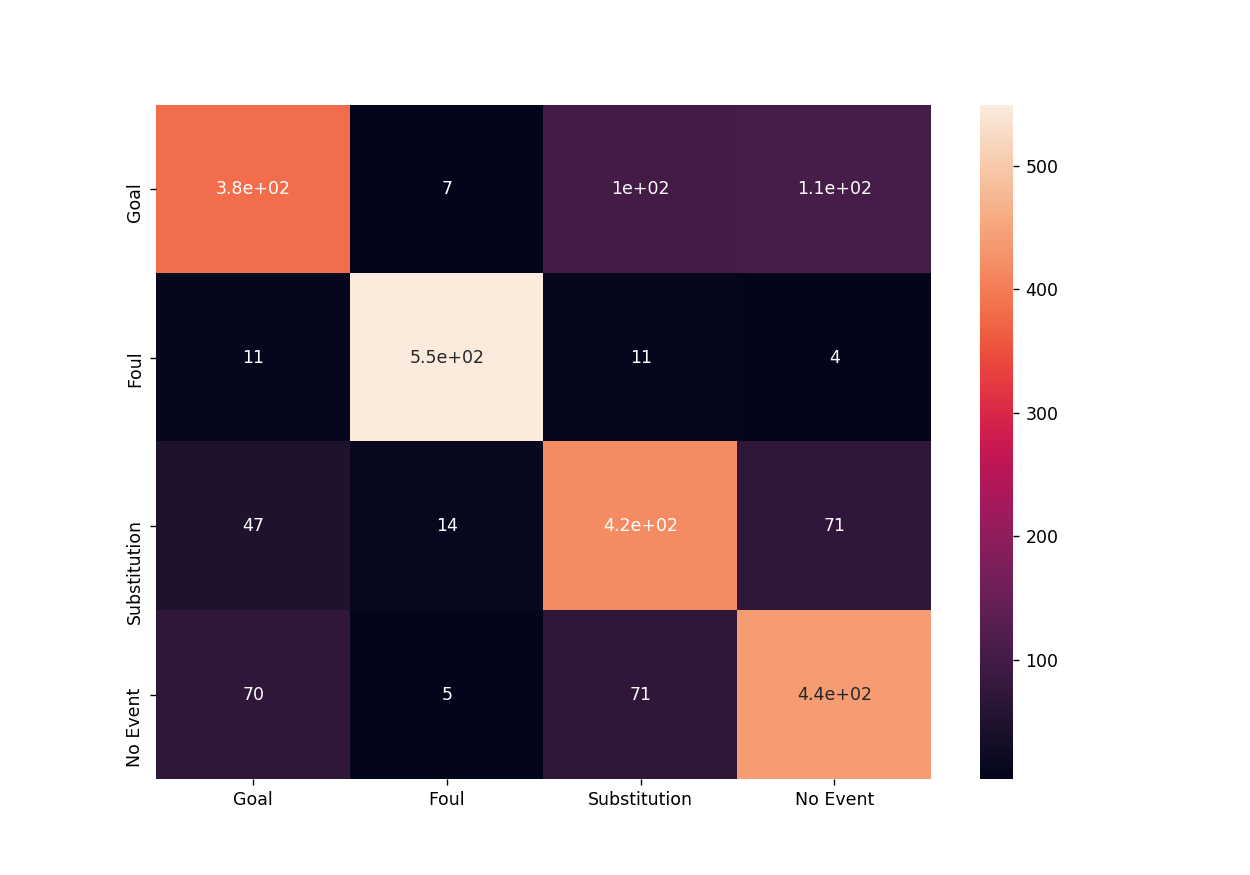

In [246]:
df_cm = pd.DataFrame(cm, index = ["Goal", "Foul", "Substitution", "No Event"],
                  columns = ["Goal", "Foul", "Substitution", "No Event"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [165]:
X_train

array([[-3.01608181e+00,  3.41025925e+00, -8.85318661e+00, ...,
        -1.12355955e-01, -9.88026485e-02, -4.64992821e-01],
       [ 1.47220716e+01, -4.60904789e+00, -8.44530582e+00, ...,
         3.67977560e-01, -3.77899647e-01,  7.65661374e-02],
       [ 1.28598127e+01, -7.36556232e-01, -1.36307917e+01, ...,
         3.12246084e-01,  3.87911201e-01,  4.63178664e-01],
       ...,
       [-2.28113365e+01, -4.24127913e+00,  3.50485849e+00, ...,
        -2.31165299e-03,  2.55263239e-01, -2.39848405e-01],
       [-2.45080414e+01, -3.03113723e+00,  1.03568993e+01, ...,
         2.83799589e-01,  5.52050769e-01, -2.45497786e-02],
       [-2.41111870e+01,  7.12151337e+00, -1.86726642e+00, ...,
         5.17653488e-02, -6.58603311e-02, -9.56835523e-02]])

In [252]:
cm

array([[382,   7, 101, 106],
       [ 11, 549,  11,   4],
       [ 47,  14, 418,  71],
       [ 70,   5,  71, 440]], dtype=int64)

In [253]:
cm.sum(axis = 0)

array([510, 575, 601, 621], dtype=int64)